In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import email
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
stop_words = set(stopwords.words('english'))
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
%autosave 60

Autosaving every 60 seconds


# Spam Email Classification with Scikit Learn

### Introduction


The Enron Spam Dataset is a collection of tens of thousands of emails which have been manually categorized into both Spam and Ham. There are two versions available - a preprocessed dataset and raw dataset. The preprocessed dataset contains the emails which have been converted into plain text format, and have been cleaned of HTML tags. The raw dataset contains the emails in their untouched form which contain the original HTML tags and various message formats, for example the '.eml' format. 

The goal of this project will be to train and evaluate different machine learning methods in classifying these emails as either ham or spam, and the Raw untouched dataset will be used in order to have full control of the process. Encorporating a cleaning step into the learning process will ensure that the model is robust in the classfication of new, unseen and 'dirty' data. This project will go through a number of steps before reaching a conclusion:

 - **Importing the data**
     -  The dataset is split into two separate folders - Ham and Spam. In each folder there are various subfolders. An efficient loading process will be developed to read in each email into their respective categories. 
     
 - **Organizing the data**
     -  Both Ham and Spam files will be combined into a pandas dataframe which will allow for simple manipulation cleaning stage, in the exploratory data stage and the model tuning stage. 

 - **Cleaning the data**
     -  Regular expressions functions will clear the email messages of html tags and other non alphanumeric noise. A lemmatizer will be applied to the emails in order to reduce words to their base format, for example: 'walking' will be converted to 'walk'.
     
 - **Creating a train and test set**
     -  The dataset will then be split into a training set and test set for use in model training. The models will be trained on the training set, and validated using the test data as 'unseen' data. 
     
 - **Feature Extraxtion with TfidfVectorizer**
     -  The dataset will then be analysed for word frequencies. This converts the data into a numerical format which is required for the machine learning algorithms. 
     
 - **Model Training and Evaluation**
     -  Model training begins at this step. Multiomial Naive Bayes, K Nearest Neighbour, Decision Tree, Random Forest and Logisitic Regression models will be trained in the training data, then validated on the test data. 
     
 - **Model Selection and Fine Tuning**
     -  The best perfoming model from the previous training segment will be tunned via Gridsearch to find its optimum parameters.  

 - **Discussion**

### Importing the data

The raw dataset, as supplied, is separated into two categories: Ham and Spam. However the folder structure is quite disorganized and the emails are divided into various subdirectories. The file structure is also disorganied, with a mixture of text and .eml file types. Using the **OS** library, the output below shows that there are 249 folders in the Ham Directory, and 34 folders in the Spam Directory.

In [4]:
hamdir = r'C:\Users\Admin\Downloads\Compressed\Ham Unprocessed'
spamdir = r'C:\Users\Admin\Downloads\Compressed\Spam Unprocessed'
dirs=[hamdir,spamdir]

def count_dirs(dirs):
    for d in dirs:
        folders = 0
        for _, dirnames, filenames in os.walk(d):
          # ^ this  means "we won't be using this value"
            folders += len(dirnames)
        print('There are',folders,'folders in the Ham Directory')

count_dirs(dirs)

There are 249 folders in the Ham Directory
There are 34 folders in the Ham Directory


In order to capture all files in the folder structure, quite a convoluted piece of code will be used. **Os.walk** will search through each subdirectory and append the files to a pre-defined list called *mylist*. However, since many of these files have different formats, the library **email** will be used. This will allow us to extract the body of the email message. 

In some cases, there is more than one level in an email ie. more than one 'body'. In the **email** library, the body of an email is known as a 'payload'. Due to the multi level emails, the extraction function has to check twice if the message body or payload is a multipart before appending the data to the list. It first checks if the message is multipart. If it is not, the message is saved. If it is a multipart email, the functions goes one level deeper and checks again if the message is multipart ie. one of two messages. If it is not, the data is saved, if it is multipart, the code can extract both messages. 

Once it finally has the payloads, this is appended to the list and iterates again over the next file in the directory. 

In [5]:
def getlist(directory):
    # this function takes the directory name, iterates over each file subdirectories
    # and appends them to the list 'mylist'
    mylist=[]
    for directory, subdirectory, filenames in  os.walk(directory):
        for filename in filenames:
            with open(os.path.join(directory, filename), "r",encoding="latin-1") as f:
                data = f.read()
             
            # the below code checks for multi part emails and appends them to 'mylist'
            b = email.message_from_string(data)
            if b.is_multipart():
                for payload in b.get_payload():
                    if payload.is_multipart():
                        for payload1 in payload.get_payload():
                            mylist.append(payload1.get_payload())
                    else:        
                        mylist.append(payload.get_payload())
            else:
                mylist.append(b.get_payload())

    return mylist

In [6]:
# sending the ham and spam directories to the getlist function
# this will return a list of emails 

hamlist=getlist(hamdir)
spamlist=getlist(spamdir)

### Organizing the data

Once both Ham and Spam lists have been created, they will be combined into a pandas dataframe which will allow for simple manipulation during cleaning stage, the exploratory data stage and the model tuning stage. FIrst, both the ham and spam lists are converted into a Pandas dataframe, giving them the column ['email'] and['target']. Target is the label variable, with 0  being ham and 1 being spam. 

Both dataframes are then concatenated to form then main dataframe called **'all_emails'** which will be used throughout this process.

In [7]:
def create_df(hamlist,spamlist):
    
    # takes both ham and spam lists and concatenated them into a dataframe
    # returns dataframe once complete

    # create dataframe of ham
    ham=pd.DataFrame(hamlist,columns =['email'])
    # add target column for ham
    ham['target']=0
    
    # do same process for spam
    spam=pd.DataFrame(spamlist,columns =['email'])
    spam['target']=1
    #concatenate ham and spam and shuffle dataframe
    all_emails=pd.concat([ham,spam])
    all_emails = all_emails.sample(frac=1).reset_index(drop=True)

    
    return all_emails

In [8]:
# send the newly created ham list and spam list to the create_df function
# this will return a new dataframe which will be saved as 'all_emails'

all_emails = create_df(hamlist,spamlist)

### Cleaning the Data

Regular expressions suitable for these email files were created and will be used on each message. URLs, HTML tags, email addresses, sequences of digits and other non-alphanumeric noise will be removed with a **clean_regex** function. A sufficiently tidy set of emails should remain, however we can go two steps further by removing stop words and lemmatizing the dataset after the regex function.

Lemmatizing is a natural language processing technique which essentially truncates words to their base form. This allows for simplifying of the dataset without losing much meaning. For example, a string with the words 'walk, walks, walked, walking' will, after lemmatization, contain only instances of the word walk. There is another similar method of cleaning text called Stemming, however I decided againt this method as there is potential for the data to end up containing words that don't exist, for example, ponies could become poni, as a stemmer simply removes the plural segment 'ies'. Lemmatizing would convert it to pony. For the lemmatization process I will be using **WordNetLemmatizer** from the nltk.stem library 

Stop words such as **'the, a, an, in'** are words of little importance and unneccesary for this type of natural language processing task. These are more than likely not the keywords that will signify whether an email is spam or ham, and are more useful for sentiment analysis. Thefore I will remove them from the collection of emails which will reduce the dimensional space of the dataset, and increase overall importance of the word space. For this process I will use the **stopwords** package from the nltk.corpus library. 

Before the cleaning process, we will check a single row for noise such as punctuation, HTML tags or URLs and stop words. This can then be compared to the same email after the cleaning process.  

In [9]:
all_emails.head(5)

,email,target
0,"Louise and John,\n\nThank you for having the m...",0
1,"<html>\n\n<head>\n<meta http-equiv=3D""Content-...",1
2,"<HTML><HEAD><META HTTP-EQUIV=3D""Content-Type"" ...",1
3,"Due to recent events, mixed messages are perme...",0
4,FYI \n\nadr\n---------------------- Forwarded ...,0


For the cleaning process I will write two functions - **clean_regex** and **clean_column**, which are contained in the two code blocks below. The dataframe to be cleaned is sent to the **clean_column** function, which works on the 'email' column of the dataset. It first applys the **clean_regex** function on each item in the 'email' column, and then moves on to stop word removal. Finally, two types of lemmatization are applied: verb and noun lemmatization, signified by the argument **pos=v** or **pos=n**.

In [10]:
def clean_regex(m):
        
        #defining the cleaning function which will run several regex search & replace
        # processes on each email
        # m for message in email column
        m = re.sub(r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$','',str(m)) # email addresses
        m = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(m)) # http/url regex
        m = re.sub(r'\d+', '', str(m)) # numbers
        m = re.sub(r'<[^<]+?>', '', str(m)) # html <tags>
        m = m.replace(r'[^a-zA-Z]', '') # non alphanumerics
        m = m.replace('nbsp', '') # common in unprocessed spam files, new html
        m = m.translate(str.maketrans('', '', punctuation)) # remove punctuation
        m = m.lower() # lower case

        return m
    
def clean_column(df,col_name):
    
    # apply clean regex to column
    df[col_name]=df[col_name].apply(clean_regex)
    
    # apply stop word removal to column
    df[col_name]=df[col_name].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))
    
    # keep only words between 3 and 15 characters long (some very long gibberish strings in some emails)
    df[col_name]=df[col_name].apply(lambda x: ' '.join([item for item in x.split() if 3 <= len(item) <= 15]))
    
    # initialize Lemmatizer
    lem = WordNetLemmatizer()
    
    # apply verb lemmatizer
    df[col_name]=df[col_name].apply(lambda x: ' '.join([lem.lemmatize(word,pos='v') for word in x.split()]))

    # apply noun lemmatizer
    df[col_name]=df[col_name].apply(lambda x: ' '.join([lem.lemmatize(word,pos='n') for word in x.split()]))
    
    return df

In [11]:
# send all_emails dataset to clean_column function
# arguments are:  dataset, column to clean

all_emails_clean = clean_column(all_emails,'email')

The whole column of emails should now be cleaned, so the same row as before can be printed to observe the results. 

In [12]:
all_emails_clean.head(5)

,email,target
0,louise john thank meet gas power origination m...,0
1,notification limit account access notification...,1
2,hey hear new drmicrog call copyiaacutelis thin...,1
3,due recent event mix message permeate appropri...,0
4,fyi adr forward audrey sharon solon ricki audr...,0


### Imbalanced Classes - Downsampling

The dataset must be split into two segments: a training set and test set for use in model training. The models will be trained on the training set, and validated using the test data as 'unseen' data.

However, before the data is split, it must be balanced due to spam comprising the larger class majority by almost a factor of 2. There are roughly 40,000 spam emails, and 19,000 ham emails. Ideally the dataset should be balanced so as to not create bias in the models during training. A high bias such as that observed in the current dataset could cause some models to predict more spam than ham in an effort to reach a higher accuracy level, and while a high accuracy level may mean that many spam emails are being classified correctly, it may also cause unwanted false positives where the model predicts a high number of ham as spam. 

I will create a function called **downsamp_maj** to downsample the majority class (spam) to the same level as the minority (ham), which is roughly 19,000 observations, and then proceed with the train test split. Even though we are removing close to 20,000 spam emails, we are still left with a large number for training so overall it is not a drastic reduction in observations. Ideally, we would just search for more ham examples to balance the dataset naturally. 

Before the downsampling begins, we can quickly check the proportion of spam to ham, where spam==1 and ham==0:

In [13]:
# check value counts before sample 
s=all_emails.target.value_counts()

print('There are',s.values[0],'spam emails and',s.values[1],'ham emails in the dataset')

There are 41032 spam emails and 19088 ham emails in the dataset


It is a highly imbalanced dataset as observed in the printout. The majority class will now be downsampled in the code below using the **resample** package from from sklearn.utils and the proportion of classes will be checked once again when the downsampling is completed. 

In [14]:
def downsamp_maj(df,target):

    # this function can be used for downsampling the majority class to match the minority class 
    # this function works for any panda dataframe with two classes labeled 0 and 1
    # arguents: panadas dataframe and response variable column name as string
    
    # get counts of both classes
    lenclass_1 = len(df[df[target]==1])
    lenclass_0 = len(df[df[target]==0])

    # if class 1 is larger than class 0
    if lenclass_1 > lenclass_0:

        # set class 1 as the majority and class 0 as minority
        df_majority = df[df[target]==1]
        df_minority = df[df[target]==0]
        
        # downsample majority to the number of classes in minority
        df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=lenclass_0,     # to match minority class
                                 random_state=123) # reproducible results 

        # join downsampled majortiy and minority into dataframe
        df = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)
        
    # otherwise downsample class 0
    else:

        df_majority = df[df[target]==0]
        df_minority = df[df[target]==1]

        df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=lenclass_1,     # to match minority class
                                 random_state=123) # reproducible results 

        # Combine minority class with downsampled majority class
        df = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)

    return df

In [15]:
# send the email dataset to the function downsamp_maj which takes the dataframe, and the name of the column
# containing the class labels, in this case the name is 'target'

balanced_emails = downsamp_maj(all_emails,'target')

# get value counts for printout
s=balanced_emails.target.value_counts()
print('There are',s.values[0],'spam emails and',s.values[1],'ham emails in the dataset')

There are 19088 spam emails and 19088 ham emails in the dataset


### Exploratory Data Analysis

Belopw are two plots of the top 20 most frequent words by class. Surprisingly, company is the top Spam word. This word seems out of place in a spam dataset but this will be re-weighted in the feature extraction stage with the TFID Vectorizer. And not surpisingly, enron is the most frequent word in the ham dataset, followed by company. The word 'company' occurs very frequently in both datasets, and may be a missed html or email tag.

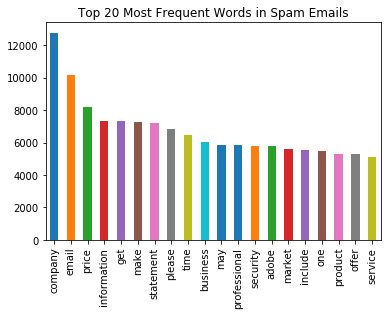

In [16]:
top_spam = pd.Series(' '.join(balanced_emails['email'][balanced_emails['target']==1]).split()).value_counts()[:20]
top_spam.plot(kind='bar')
plt.title('Top 20 Most Frequent Words in Spam Emails')
plt.show()


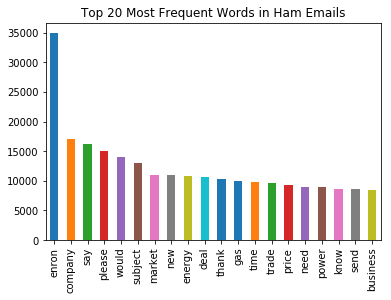

In [17]:
top_ham = pd.Series(' '.join(balanced_emails['email'][balanced_emails['target']==0]).split()).value_counts()[:20]
top_ham.plot(kind='bar')
plt.title('Top 20 Most Frequent Words in Ham Emails')
plt.show()

### Train Test Split

The train test split process can now begin. In order to asses the performance of varios models, a training set and test set is needed. The train set will be used to train the models, and then the models will be evaluated on the test set. The split proportion is usally 80/20 train/test or 70/30 train test. For this project I will be splitting the data 70/30 ie. 70% of the data will be used for training, and 30% for evaluation.

The function below randomly separates the dataframe and returns four pandas series - xtrain, xtest, ytrain and ytest. 

**xtrain:** These are the predictor variables, in this case just one variable which is the collection of emails. And since it is the training set, it contains 70% of the emails. **ytrain:** This is the correspinding class labels [0,1] for the emails in xtrain. **xtest:** These are the emails used for validation - 30% split. **ytest:** These are the corresponding class labels [0,1] for the emails in our test set above. 

In [18]:
def tt_split(df):
    
    xtrain, xtest, ytrain, ytest = train_test_split(df['email'], df['target'], test_size=0.3,random_state=5)
    
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = tt_split(balanced_emails)

### Feature Extraction with TFID Transformer

In order to train the models with the email data, it will need to be converted to numerical format. One useful method is to transform the data using sklearn's TFID Transformer. TFID stands for *'Term Frequency Inverse Document'*. Term Frequency records the number of times a word appears in a document to the total number of words in that document. The more times a word increases in each document, the higher the ratio or term frequency of that word. Each document has its own term frequency ratio. 

After recording the Term Frequency, the inverse data frequency process is used to calculate the weight of words across all documents in the dataset. Words that rarely occur have a high 'IDF' score. The IDF of common words will approach zero, which shows they are not significant. For example, if the word 'the' is present in every email, it is of no use to learning algorithms, therefore will have a low IDF score. Words which appear less commonly will have a higher IDF. The Term Frequency and IDF are then combined to give the TFIDF score. This process adjusts the weight of words which in turn adjusts their significance.

In the below code block I transform the data using the sklearn TfidfVectorizer. The n_gram argument of TfidfVectorizer also checks for pairs or triplets of words, for example, 'very expensive' instead of just the single words 'very' and 'expensive'. This paring of words may give more insight into the document context. In this instance n_grams=2 is chosen. Performing this tranformation results in two new vectors which can be used for training and testing: **xtrain_tfid** and **xtest_tfid.**

In [19]:
def tfid_vec(train,test):
    
    # initialize vectorizer - we will check ngrams up to length 2
    transformer = TfidfVectorizer(ngram_range=(1,2),min_df=5)
    
    # using the vectorizer to transform the training and test data to numerical values.  
    train_tfid = transformer.fit_transform(train)
    test_tfid = transformer.transform(test)
    
    return train_tfid,test_tfid

xtrain_tfid,xtest_tfid = tfid_vec(xtrain,xtest)

### Model Training and Evaluation

Various models will now be trained:: Multiomial Naive Bayes, K Nearest Neighbour, Decision Tree, Random Forest and Logisitic Regression models will each take the xtrain subset along with the class labels of that subset: ytrain. Each model will be initialized with their default settings, and then evaluated by recording various metrics such as precision, confusion matrix and accuracy. The best performing model will be isolated, then optimized to get the maxmimum possible accuracy metric via hyperparameter tuning using GridSearch. First I will initialize and train the models on the training data **xtrain.**

In [20]:
# Multinomial Naive Bayes
mymodelNB = MultinomialNB().fit(xtrain_tfid, ytrain)

#K Nearest Neightbours
mymodelKNN = KNeighborsClassifier().fit(xtrain_tfid,ytrain)

#Decision Tree
mymodelDT= tree.DecisionTreeClassifier().fit(xtrain_tfid,ytrain)

# Random Forest
mymodelRF = RandomForestClassifier().fit(xtrain_tfid, ytrain)

# Logistic Regression
mymodelLR = LogisticRegression().fit(xtrain_tfid,ytrain)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


To evaluate the models I will create two functions. The first is **plot_matrix** which creates a visually pleasing confusion matrix plot and takes as arguments the test labels, the predicted classes from the models, the class names and the name of the model. This will then be called in the second function **evaluate_models** which will first predict which class the 'unseen' test emails belong to using the model.predict function, then computes the accuracy score, classification report and ROC curve. The arguments for this function are: the model, test emails and test labels. 

In [21]:
def plot_matrix(ytest,ypreds,classes,title):
    # Code adapted and tweaked from scikit-learn.org

    cm=confusion_matrix(ytest, ypreds,labels=[1,0])
  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [22]:
def evaluate_model(model,xtest,ytest):
    
    # get class predictions
    ypreds=model.predict(xtest)
    
    # get class probabilities for use in ROC curve
    yprobs=model.predict_proba(xtest)[:,1]
    
    # set model name
    model_name = type(model).__name__
    
    print('\n---------',model_name,'---------\n')
    
    # accuracy score
    score = metrics.accuracy_score(ytest, ypreds, normalize=True, sample_weight=None)
    print('\n\nAcruacy score of ',score)
    
    # call plot_matrix function 
    classes=['spam','ham']
    plt.figure()
    plot_matrix(ytest,ypreds,classes,model_name)
    
    # classification report

    print(metrics.classification_report(ytest, ypreds,target_names=['Spam','Ham']))
    
    # Compute false positive rate, true positive rate, thresholds and area under the ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, yprobs)
    roc_auc = roc_auc_score(ytest, yprobs)
    
    plt.figure()
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.legend(loc="best")
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC '+model_name)
    
    return score,model_name

Now that the functions have been set up, each trained model can be passed into the **evaluate_model** function, with accuracy recorded in a results list.


--------- MultinomialNB ---------



Acruacy score of  0.9359993014930585
              precision    recall  f1-score   support

        Spam       0.89      0.99      0.94      5712
         Ham       0.99      0.88      0.93      5741

   micro avg       0.94      0.94      0.94     11453
   macro avg       0.94      0.94      0.94     11453
weighted avg       0.94      0.94      0.94     11453



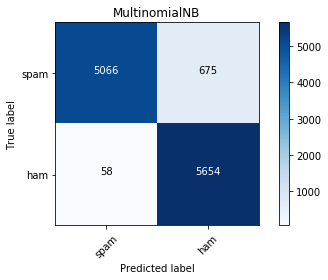

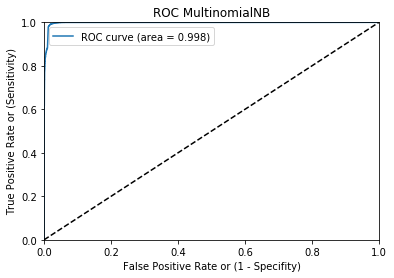

In [23]:
#Multinomial Naive Bayes Performance Metrics

results=[]

score,model_name=evaluate_model(mymodelNB,xtest_tfid,ytest)

results.append((model_name,score))


--------- KNeighborsClassifier ---------



Acruacy score of  0.6342443028027591
              precision    recall  f1-score   support

        Spam       1.00      0.27      0.42      5712
         Ham       0.58      1.00      0.73      5741

   micro avg       0.63      0.63      0.63     11453
   macro avg       0.79      0.63      0.58     11453
weighted avg       0.79      0.63      0.58     11453



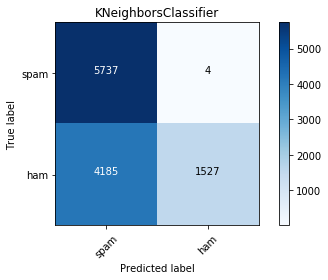

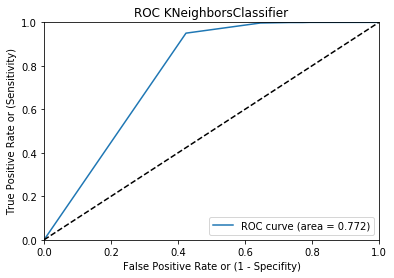

In [24]:
#K Nearest Neighbours Performance Metrics

score, model_name = evaluate_model(mymodelKNN,xtest_tfid,ytest)

results.append((model_name,score))


--------- DecisionTreeClassifier ---------



Acruacy score of  0.9551209290142321
              precision    recall  f1-score   support

        Spam       0.95      0.96      0.96      5712
         Ham       0.96      0.95      0.96      5741

   micro avg       0.96      0.96      0.96     11453
   macro avg       0.96      0.96      0.96     11453
weighted avg       0.96      0.96      0.96     11453



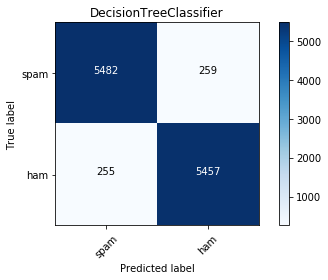

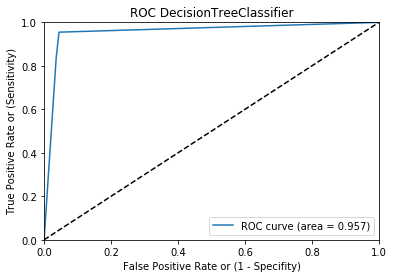

In [25]:
#Decision Tree Performance Metrics

score,model_name = evaluate_model(mymodelDT,xtest_tfid,ytest)

results.append((model_name,score))


--------- RandomForestClassifier ---------



Acruacy score of  0.9615821182222999
              precision    recall  f1-score   support

        Spam       0.95      0.98      0.96      5712
         Ham       0.98      0.95      0.96      5741

   micro avg       0.96      0.96      0.96     11453
   macro avg       0.96      0.96      0.96     11453
weighted avg       0.96      0.96      0.96     11453



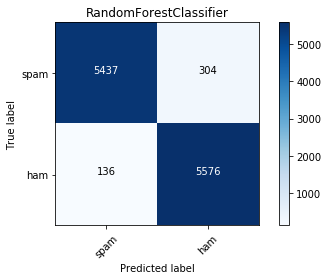

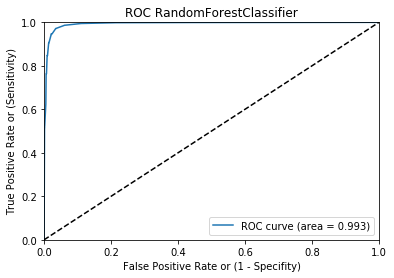

In [26]:
#Random Forest Performance Metrics**

score,model_name = evaluate_model(mymodelRF,xtest_tfid,ytest)

results.append((model_name,score))


--------- LogisticRegression ---------



Acruacy score of  0.9797432986990309
              precision    recall  f1-score   support

        Spam       0.99      0.97      0.98      5712
         Ham       0.97      0.99      0.98      5741

   micro avg       0.98      0.98      0.98     11453
   macro avg       0.98      0.98      0.98     11453
weighted avg       0.98      0.98      0.98     11453



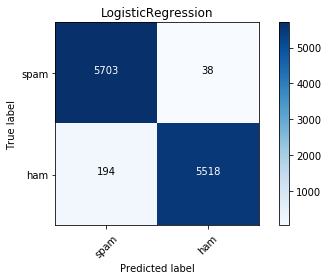

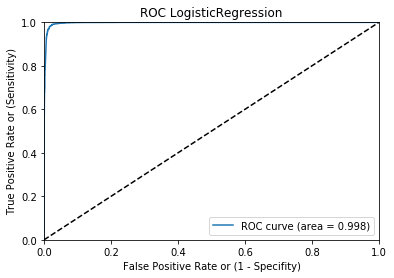

In [27]:
#Logistic Regression Performance Metrics

score,model_name = evaluate_model(mymodelLR,xtest_tfid,ytest)

results.append((model_name,score))

In [28]:
for name,score in results:
    print(name,round(score,4))

MultinomialNB 0.936
KNeighborsClassifier 0.6342
DecisionTreeClassifier 0.9551
RandomForestClassifier 0.9616
LogisticRegression 0.9797


## Model Selection and Fine Tuning

The above list of accuracy scores shows that **Logistic Regression** is the highest performing model in terms of accuracy rate. Indeed it also has a very good AUC (Area under ROC curve). The AUC tells us the predicitve power of the model and how well it can distinguish between classes. An AUC of 1 is a perfect result, and the Logistic Regression model is very close with a low false negative rate. The precision score is also very high, which is the proportion of positive (spam) predicitons that were actually correct. Second best is the Multinomial Naive Bayes model, however it has a lower precision and higher false negative rate. Although the performance metrics of the Logistic Regression model are very good, one last hyperparameter grid search will be carried out to see if it is in any way possible to increase the performance metrics even further. 

**'C' parameter:** A regularization function. A smaller number for C specifies a stronger regularization. Default is 1. Regularization can reduce the problem of overfitting, however if if C too large, the model my overfit on the data and won't generalize well on test data. If C is too small, the data complexity will be lowered, or over-regularized, which will cause underfit. For this grid search I will test the regularization factor from 0.001 to 1000 in steps of 10.

**'Penalty' parameter:** Two loss functions: L1 and L2. L2 minimizes sum of squares error, and L1 minimizes absolute error. 

In [29]:
grid_params = {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"]}
log_grid  = LogisticRegression()
mymodelLR_Grid = GridSearchCV(log_grid,param_grid=grid_params,cv=10,n_jobs=-1)
mymodelLR_Grid = mymodelLR_Grid.fit(xtrain_tfid,ytrain)
print("Best hpyerparameters : ",mymodelLR_Grid.best_params_)
print("Accuracy :",mymodelLR_Grid.best_score_)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best hpyerparameters :  {'C': 1000, 'penalty': 'l2'}
Accuracy : 0.9881749803540022


The values C = 1000 and Penalty = L2 were chosen as the best parameters. This new logistic regression model will now be used on the test data to ascertain if the performance has increased. It will be initialized as 'best_LR', and sent to the  **evaluate_model** function.


--------- LogisticRegression ---------



Acruacy score of  0.9873395616868943
              precision    recall  f1-score   support

        Spam       0.99      0.98      0.99      5712
         Ham       0.98      0.99      0.99      5741

   micro avg       0.99      0.99      0.99     11453
   macro avg       0.99      0.99      0.99     11453
weighted avg       0.99      0.99      0.99     11453



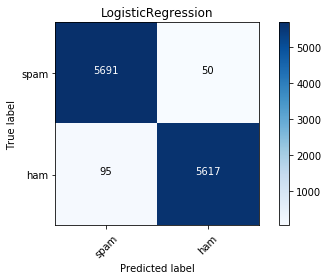

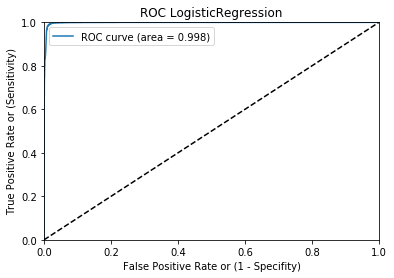

In [30]:
best_LR = mymodelLR_Grid.best_estimator_
score,model_name = evaluate_model(best_LR,xtest_tfid,ytest)

As we can see, these new parameters have boosted the accuracy score of the Logistic Regression model. The model can now be saved using the pickle library for later use.

In [31]:
import pickle

# save the model to disk

filename = 'Best_Model_LogiRegression.sav'
pickle.dump(best_LR, open(filename, 'wb'))


## Discussion

From the various models created in this project, the Logistic Regression model came out on top, followed closely by Multinomial Naive Bayes. It might be difficult to improve this model more - perhaps more training data would be useful to increase the accuracy rate. Roughly 20,000 'ham' emails were removed to balance the dataset. It is yet to be seen whether upsampling the 'spam' emails would improve or worsen the results. 

For real world use, it is difficult to say if this model would be suitable. The dataset came from an American corporate environment, specifically the Enron corporation which closed in 2007. There are some unanswered questions that are outside of the scope of this project. Would the model generalize well to data from emails outside of the corporate world? Or even emails outside of America? Would it work on emails ten years later in the the year 2019? Personal 'ham' emails would have more casual langauge, in the year 2007 or present day. This model has also been tuned on the English language only. As a general spam filter, this may work OK in an English speaking corporate environment, but more data is needed from other sources to truly say if it can generalize well as a spam filter.

